In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
# import pyximport; pyximport.install()
from PedestrianCrowding import Road
from multiprocessing import Pool, Manager
import itertools
import pandas as pd
import plot_init as pu
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# matplotlib.rcParams.update(pu.params)
matplotlib.rcParams.update(pu.params)

## Run this when we are sure about our figures
# plt.rcParams["text.usetex"] = True

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

markers = ['o','^']

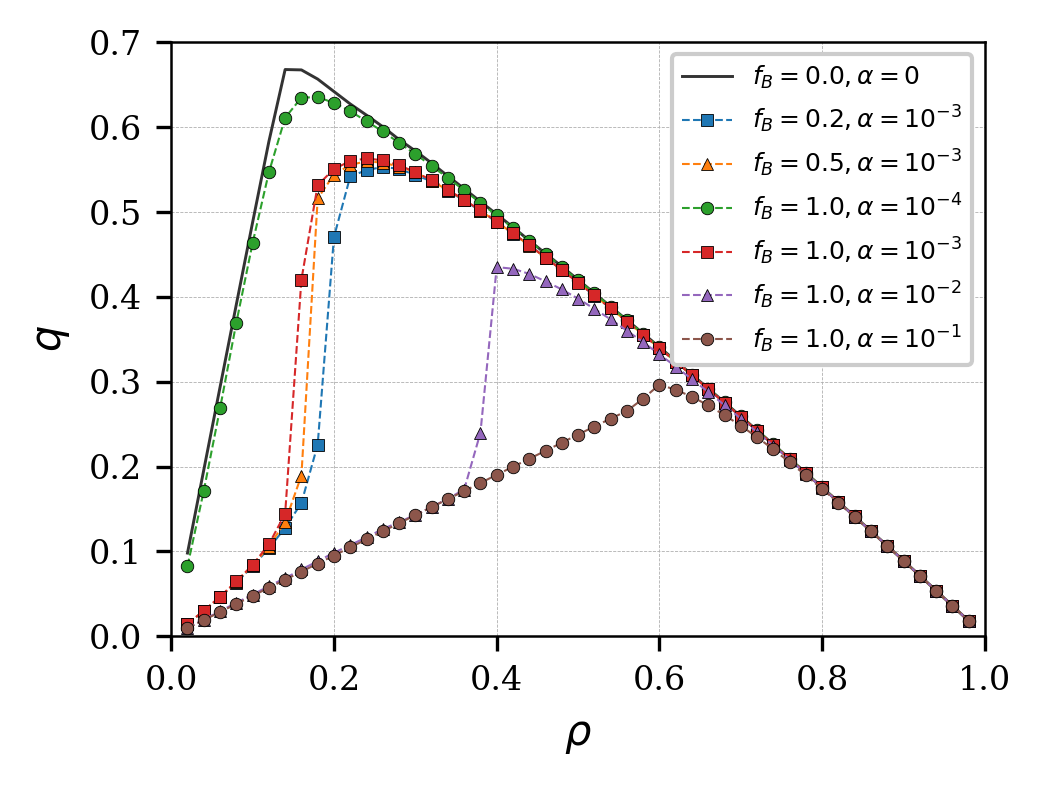

In [14]:
plt.rc('font', family='serif')
# df = pd.read_csv("../data/alpha_transitions_parallel.csv")
df = pd.read_csv("../data/dataset_safe_decel.csv")
df.sort_values(["frac_bus", "alpha"], inplace=True, ascending=[True, True])

i=0
markers = ['o','s','^']
alpha_list = np.geomspace(1e-4, 1e-1, 4)
fig, axes = plt.subplots(1,1, dpi=300, sharey=True)
for (bus_frac, alpha), grouping in df.groupby(["frac_bus", "alpha"]):
    if (alpha==1e-3 and (bus_frac in [0, 0.2, 0.5])) or (bus_frac==1 and (alpha in alpha_list)):
        label = r"$f_B=%.1f,\alpha=10^{%1d}$"%(bus_frac, np.log10(alpha))
        marker = markers[i%len(markers)]
        ls = '--'
        color=None
        lw=0.5
        if bus_frac==0:
            alpha=0
            label = r"$f_B=%.1f,\alpha=0$"%bus_frac
            marker=None
            ls=None
            color='0.2'
            lw=0.7
        throughput_group = grouping.groupby(["density", "alpha","frac_bus"])["throughput"]
        throughput = throughput_group.agg([np.median, percentile(0.25), percentile(0.75)]).reset_index()
        axes.errorbar(throughput["density"], throughput["median"],#/throughput["density"], 
                         marker=marker, label=label, color=color,
                         ms=3, linewidth=lw, markeredgecolor='k', markeredgewidth=0.2,
                         ls=ls, capsize=2)
        i+=1
        

axes.grid()
axes.legend(fontsize=6)
axes.set_xlabel(r"$\rho$")
axes.set_ylabel(r"$q$")
axes.set_ylim(bottom=0)
axes.set_xlim(0,1)

# axes.set_ylabel(r"$q$")

fig.savefig("../images/fundamental_diagram_single_lane.pdf", bbox_inches="tight")

# Spatiotemporal Diagrams

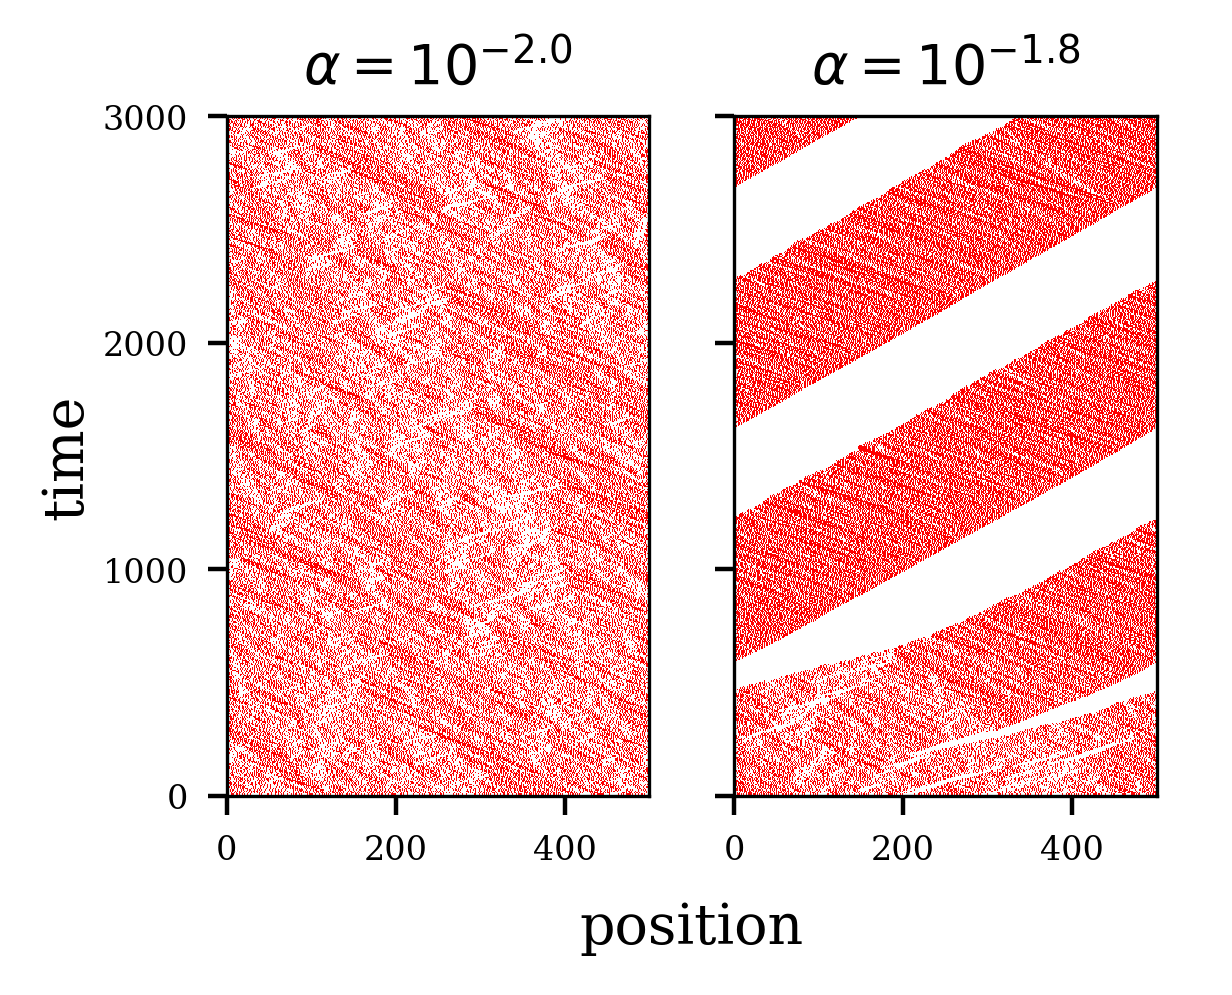

In [4]:
%run -i std_comparison.py

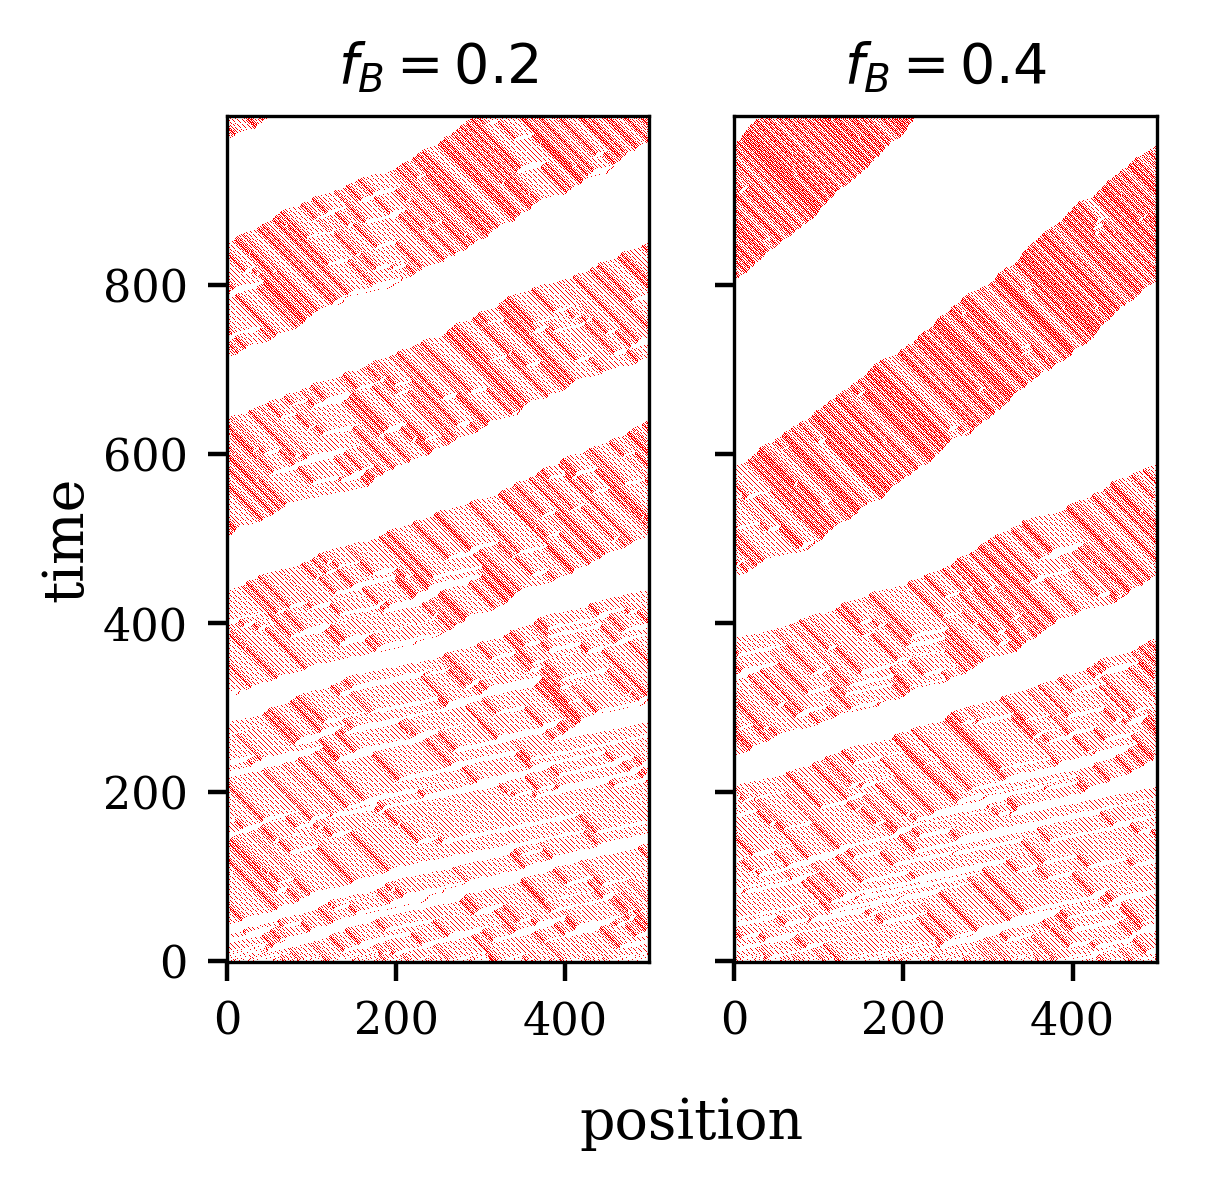

In [5]:
alpha1 = 10**-3

frac_bus1 = 0.2
frac_bus2 = 0.4

road1 = Road(roadlen, num_lanes, vmax=5, alpha=alpha1, frac_bus=frac_bus1, periodic=True, density=0.18, p_slow=0.)
road2 = Road(roadlen, num_lanes, vmax=5, alpha=alpha1, frac_bus=frac_bus2, periodic=True, density=0.18, p_slow=0.)

T = 1000
num_subplots = 2

std = np.zeros((num_subplots, T, num_lanes, roadlen))
for i in range(T):
    std[0,i] = road1.road
    std[1,i] = road2.road
    road1.timestep_parallel()
    road2.timestep_parallel()

fig_width = 3
my_cmap = matplotlib.cm.get_cmap('gray_r')
my_cmap.set_over('r')
fig, axes = plt.subplots(1,num_subplots,figsize=(fig_width,fig_width/num_subplots*(T/roadlen)), dpi=400, sharey=True, sharex=True)
if num_subplots == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    im = ax.imshow(1*(std[i,:,0,:]), origin="lower", cmap=my_cmap, vmax=1.001)

axes[0].set_title(r"$f_B=%.1f$"%(frac_bus1))    
axes[1].set_title(r"$f_B=%.1f$"%(frac_bus2))    

ax_par = fig.add_subplot(111, frameon=False)
ax_par.set_xlabel("position")
ax_par.set_ylabel("time")
ax_par.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


# Phase transitions in alpha

In [6]:
sim_time = 3000
trans_time = 1000
num_lanes = 1

def simulate(density, frac_bus, trial, alpha):
    roadlength = 200
    vmax = 5
    alpha = alpha
    frac_bus = frac_bus
    density = density
    p_slow = 0
    periodic = True
    throughputs = []
    road = Road(roadlength, num_lanes, vmax, alpha, 
                        frac_bus, periodic, density, p_slow)
    for t in range(sim_time+trans_time):
        road.timestep_parallel()
        if t >= trans_time:
            throughputs.append(road.throughput())
    return {"throughput": np.mean(throughputs),
            "frac_bus": frac_bus,
            "density": road.get_density(),
            "trial": trial,
            "alpha": alpha, 
            "p_slow": 0}

densities = np.arange(0.02, 1, 0.02)
bus_fractions = np.linspace(0, 1/num_lanes, 5)
trials = range(50)
alphas = np.geomspace(1e-4, 1, 49)
p = Pool()
# s = p.starmap(simulate, itertools.product(densities, bus_fractions, trials, alphas))
# df = pd.DataFrame(s)
# df.to_csv("alpha_transitions_parallel.csv")

In [7]:
# # df = pd.read_csv("../data/alpha_transitions_parallel.csv")
# df = pd.read_csv("../data/dataset.csv")

# df['speed'] = df["throughput"]/df["density"]

# fig, ax = plt.subplots(1,1, figsize=(3,9/4), dpi=300)

# ps = pd.pivot_table(df[df["frac_bus"]==1], values="speed", index="alpha", columns="density", aggfunc='median')
# alphas = np.geomspace(1e-4, 1, 49)

# densities = np.arange(0.02, 1, 0.02)

# start = 9
# stop = -1
# skip = 5
# for i, data in enumerate(ps.values[:,start:stop:skip].T):
#     density = densities[i*skip+start]
#     if density < 0.9:
#         ax.plot(alphas, data, label=r"$\rho=%.1f$"%(density), 
#                 marker=markers[i%2],  ms=3, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.15, ls='--')

# ax.set_xscale('log')
# ax.set_xlabel(r"$\alpha$")
# ax.set_ylabel(r"$\bar{v}$")
# ax.legend(fontsize=7)
# ax.grid()
# ax.yaxis.set_major_locator(plt.MultipleLocator(1))


# fig.savefig("../images/lambda_crossover.pdf", bbox_inches="tight")



In [8]:
# df = pd.read_csv("../data/dataset.csv")
# df['speed'] = df["throughput"]/df["density"]

# bus_fractions = np.linspace(0,1,11)
# fig, ax = plt.subplots(1,1, figsize=(3,9/4), dpi=300)
# for frac_bus in [1,4,7,10]:
#     bus_frac = bus_fractions[frac_bus]
#     filtered_df = df[df["frac_bus"]==bus_frac]

#     ps = pd.pivot_table(filtered_df, values="speed", index="alpha", columns="density")

#     dens = []
#     alpha_ind = []
#     for row in ps.T.values:
#         slope = np.max(np.abs(np.gradient(row)))
#         tolerance = 0.005/np.diff(np.log10(alphas))[0]
#         index = np.argmax(np.abs(np.gradient(row))) if slope>tolerance else None
#         alpha_ind.append(index)

#     dens = ps.T.index
#     ax.plot(dens, [alphas[i] if i else None for i in alpha_ind ], 'o--', 
#             label=r"$f_B=%.1f$"%bus_frac, ms=3, markeredgewidth=0.1, markeredgecolor='k', lw=0.5)
# ax.legend(loc='best')
# # ax.axhline(0.000390625)
# ax.grid()
# ax.set_yscale('log')
# ax.set_xlabel(r'$\rho$')
# ax.set_ylabel(r'$\alpha^*$')
# ax.set_title('unsafe decelerations')
# # fig.savefig("../images/lambda_crit.pdf", bbox_inches="tight")

In [9]:
# df = pd.read_csv("../data/dataset_safe_decel.csv")
# df['speed'] = df["throughput"]/df["density"]
# alphas = np.geomspace(1e-4, 1, 49)

# bus_fractions = np.linspace(0,1,11)
# bus_fractions = [0.1, 0.4, 0.7, 1]
# fig, ax = plt.subplots(1,1, figsize=(3,9/4), dpi=300)
# for bus_frac in bus_fractions:
# #     bus_frac = bus_fractions[frac_bus]
#     filtered_df = df[df["frac_bus"]==bus_frac]

#     ps = pd.pivot_table(filtered_df, values="speed", index="alpha", columns="density", aggfunc="median")

#     dens = []
#     alpha_ind = []
#     for density, row in ps.T.iterrows():
#         slope = np.max(np.abs(np.gradient(row)))
#         tolerance = 0.005/np.diff(np.log10(alphas))[0]
#         index = np.argmax(np.abs(np.gradient(row))) if slope>tolerance else None
#         alpha_ind.append(index)


#     dens = ps.T.index
#     ax.plot(dens, [alphas[i] if i else None for i in alpha_ind ], 'o--', 
#             label=r"$f_B=%.1f$"%bus_frac, ms=3, markeredgewidth=0.1, markeredgecolor='k', lw=0.5)
# ax.legend(loc='best')
# # ax.axhline(0.000390625)
# ax.grid()
# ax.set_yscale('log')
# ax.set_xlabel(r'$\rho$')
# ax.set_ylabel(r'$\alpha^*$')
# ax.set_title('safe decelerations')

# # fig.savefig("../images/lambda_crit.pdf", bbox_inches="tight")

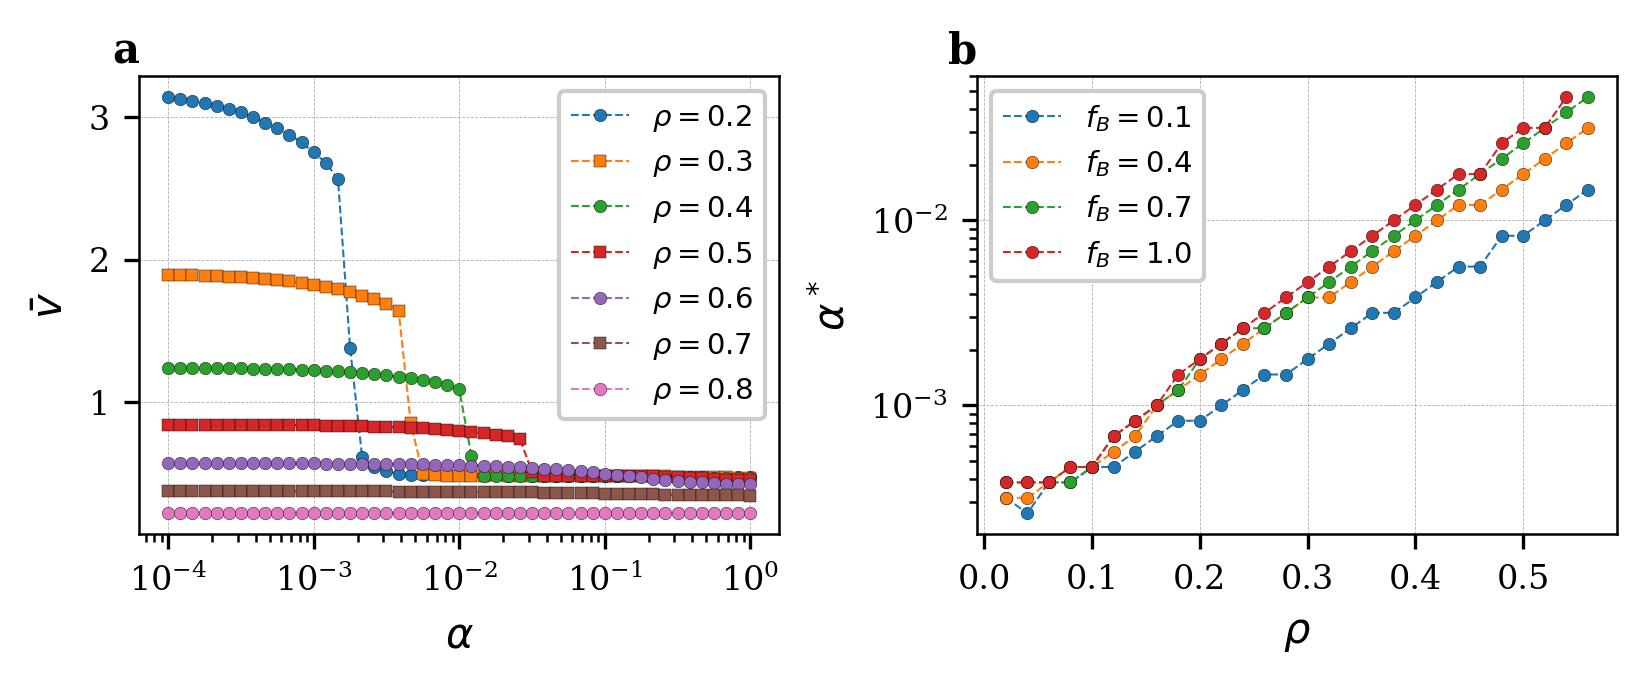

In [16]:
# df = pd.read_csv("../data/alpha_transitions_parallel.csv")
df = pd.read_csv("../data/dataset_safe_decel.csv")
df['speed'] = df["throughput"]/df["density"]

fig, ax = plt.subplots(1,2, figsize=(5.5,2.3), dpi=300)

ps = pd.pivot_table(df[df["frac_bus"]==1], values="speed", index="alpha", columns="density", aggfunc="median")
alphas = np.geomspace(1e-4, 1, 49)
densities = np.arange(0.02, 1, 0.02)

start = 9
stop = -1
skip = 5
for i, data in enumerate(ps.values[:,start:stop:skip].T):
    density = densities[i*skip+start]
    if density < 0.9:
        ax[0].plot(alphas, data, label=r"$\rho=%.1f$"%(density), 
                marker=markers[i%2],  ms=3, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.1, ls='--')
ax[0].text(0, 1.01, "a", transform=ax[0].transAxes,
  fontsize=10, fontweight='bold', va='bottom', ha='right')
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel(r"$\bar{v}$")
ax[0].legend()
ax[0].grid()
ax[0].yaxis.set_major_locator(plt.MultipleLocator(1))


bus_fractions = [0.1, 0.4, 0.7, 1]
for i, bus_frac in enumerate(bus_fractions):
    filtered_df = df[df["frac_bus"]==bus_frac]
    ps = pd.pivot_table(filtered_df, values="speed", index="alpha", columns="density", aggfunc="median")

    dens = []
    alpha_ind = []
    for density, row in ps.T.iterrows():
        slope = np.max(np.abs(np.gradient(row)))
        tolerance = 0.005/np.diff(np.log10(alphas))[0]
        index = np.argmax(np.abs(np.gradient(row))) if slope>tolerance else None
        alpha_ind.append(index)
        
    dens = ps.T.index
    ax[1].plot(dens, [alphas[i] if i else None for i in alpha_ind ], 'o--', 
            label=r"$f_B=%.1f$"%bus_frac, ms=3, markeredgewidth=0.1, markeredgecolor='k', lw=0.5)
ax[1].text(0, 1.01, "b", transform=ax[1].transAxes,
  fontsize=10, fontweight='bold', va='bottom', ha='right')
ax[1].legend(loc='best')
ax[1].grid()
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\rho$')
ax[1].set_ylabel(r'$\alpha^*$')
plt.tight_layout()

fig.savefig("../images/lambda_crossover.pdf", bbox_inches="tight")



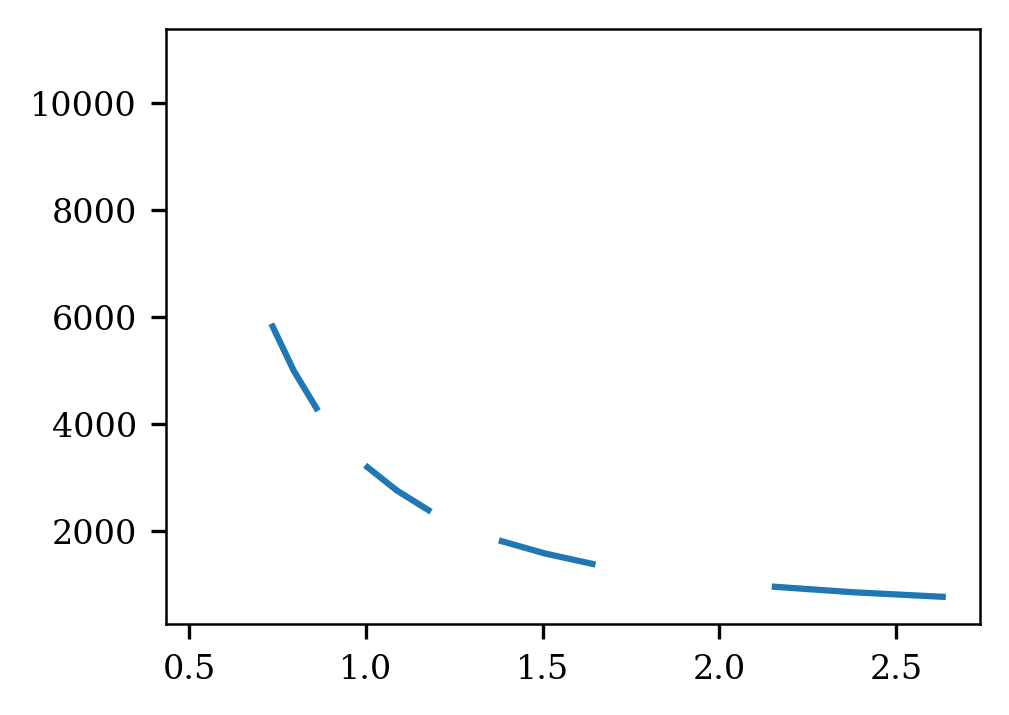

In [11]:
dens, alpha_ind
speeds = []
theo_speed = []
for i in alpha_ind:
    if i is not None:
        d = dens[i]
        a = alphas[i]
        mmm = df[(df.alpha==a) & (df.density==d) & (df.frac_bus==bus_frac)]['speed'].mean()
        speeds.append(mmm)
        theo_speed.append(roadlen**2*a/d)
    
plt.plot(speeds, theo_speed)

# Adding Passenger Capacity

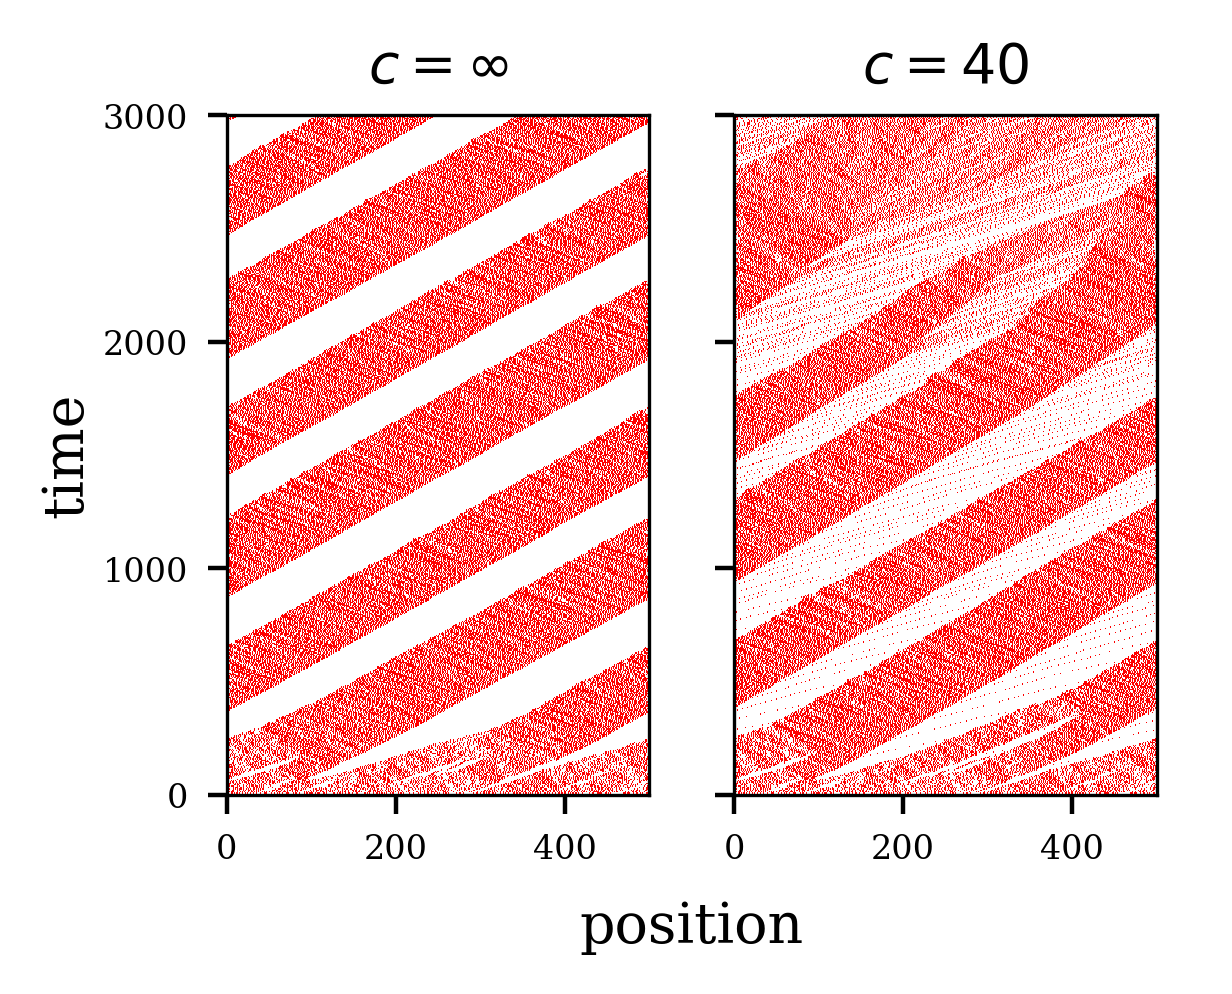

In [12]:
roadlen = 500
num_lanes = 1
# randseed = np.random.get_state()
# alpha1 = 10**-2.3
# alpha2 = 10**-1.9

density = 0.4
alpha = 10**-1.6
max_passengers = 40

frac_bus = 1/num_lanes

T = 3000
timefactor = 6
num_subplots = 2

np.random.seed(2882936862)
road1 = Road(roadlen, num_lanes, vmax=5, alpha=alpha, frac_bus=frac_bus, 
             periodic=True, density=density, p_slow=0.1)
std = np.zeros((num_subplots, T, num_lanes, roadlen))
for i in range(T):
    std[0,i] = road1.get_road()
    road1.timestep_parallel()
    
np.random.seed(2882936862)
road2 = Road(roadlen, num_lanes, vmax=5, alpha=alpha, frac_bus=frac_bus, 
         periodic=True, density=density, p_slow=0.1, max_passengers=max_passengers)
for i in range(T):
    std[1,i] = road2.get_road()
    road2.timestep_parallel()

fig_width = 3
my_cmap = matplotlib.cm.get_cmap('gray_r')
my_cmap.set_over('r')
fig, axes = plt.subplots(1,num_subplots,figsize=(fig_width,fig_width/num_subplots*(T/roadlen/timefactor)*1.5), dpi=400, sharey=True, sharex=True)
if num_subplots == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    im = ax.imshow(1*(std[i,::timefactor,0,:]), origin="lower", cmap=my_cmap, vmax=1.001, 
                   extent=(0,roadlen,0,T), aspect="auto")

axes[0].set_title(r"$c=\infty$")    
axes[1].set_title(r"$c={%d}$"%max_passengers) 
axes[0].tick_params(axis="x", labelsize=6)
axes[0].tick_params(axis="y", labelsize=6)
axes[1].tick_params(axis="x", labelsize=6)
axes[0].locator_params(nbins=3)

ax_par = fig.add_subplot(111, frameon=False)
ax_par.set_xlabel("position")
ax_par.set_ylabel("time")
ax_par.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.savefig("../images/std_comparison_capacity.pdf", bbox_inches="tight")

In [17]:
!tar -czf images.tar ../images/

tar: Removing leading `../' from member names
